### This experiment compares stats of logical and task sessions in Jones et al., Lucchess et al., and Hagen et al.

#### Results reported in the paper.

1. Basic stats for Section 3


#### Important details:
- All events where users were not "on" are filtered out in the first pass, all the rest works on the cleaned log.
- For logical session, we set 90 minutes "user leave" threshold. This may change the performance of physical session. Performance of threhold beyond 90 minutes would be influenced. 
- When creating logical sessions, session length <= 0 sec are filtered out

# Setup

In [2]:
%matplotlib inline
import pymongo
from pymongo import MongoClient
import numpy as np
import itertools
import urllib
import sys
sys.path.append('../variables/')
import UserActivity
import matplotlib
import matplotlib.pylab as pylab
from bson.objectid import ObjectId
from scipy.stats import gaussian_kde, ks_2samp, mannwhitneyu, chi2_contingency

outputdir = 'plots/'

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2

# DB connections
client = MongoClient()
db = client.db_tasklog_clean
# Collections
User = db.user
Log = db.log_chrome
Labelled = db.data_labeled
UserTasks = db.user_tasks

# Tasks to be excluded
to_exclude = ['000', '001', '002', '003', '004']
# Pre-defined labels - excluding "not sure (001)"
pre_tasks = ['001', '002', '003', '004']
# new query 
query_events = ['tab-search-new', 'tab-search-verticle'] 
# Get user task activities
# Set dummy parameters
t_thresh = -1 # Look at first X minutes, not used
session_thresh = 30 # in minutes, threshold to consider users have left without closing the tab, not used
to_include = [] # Not used for this computation 

## Function for effective size for M-U test

In [3]:
def ef_MU(sample1, sample2, h="two-sided"):
    print h
    total_pairs = len(sample1) * len(sample2)
    support = 0
    for pair in itertools.product(sample1, sample2):
        diff = pair[0] - pair[1] 
        if h == 'less' and diff < 0:
            support += 1
        elif h == 'greater' and diff > 0:
            support += 1
        elif h == "two-sided" and not diff == 0:
                support += 1
        #print pair[0], pair[1], diff, support
    return float(support)/total_pairs

#s1 = [0, 1, 2]
#s2 = [0, 0, 1]
#ef_MU(s1, s2, h='greater')

## Function to get all events for a user

In [4]:
# All events
def event_stream(data):
    events = []
    # data consists of tab-groups
    for s in data:
        tab_group = s['tab_group']
        tabid = s['tabid']
        # tab groups consist of url groups
        for ug in tab_group:
            # a group of events sharing the same url
            url_group = ug['url_group']
            for e in url_group:
                events.append(e)
    events.sort(key=lambda x: x['timestamp_bson'])
    return events

## Prepare user activity data for analysis

### Return:
* Stream of user events: {userid, [(event, user_on), (event, user_on)...]}
* Filter out events where users were not "on" the page

In [21]:
# Gether user activity data for analysis
UA = []
users = list(User.find({}))
for u in users:
    userid = u['userid']
    data = list(Labelled.find({'userid': u['userid']}))[0]['data']
    events = event_stream(data)
    ua = UserActivity.UserActivity(data, to_include, t_thresh, session_thresh)
    a_path, a_stream = ua.get_user_path()
    
    # filter out events where user was not on the tab
    user_stream = list(itertools.ifilter(lambda x: x[1] == True, a_stream))
    UA.append((userid, user_stream))

## Function to map events to event types

In [6]:
# Merge events into a few categories:
# The merge is based on: how the event were generated, and they generally have similar HTM ratios
# - query
# - link_click
# - form_submit
# - forward_back
# - go_to_url
# - pagination
# - tab_new
# - tab_close
# - tab_switch
# - tab_loading
# The two events that don't have a category: tab-search-noquery navigation-manual_subframe
def get_event_category(event):
    #These event usually will follow/followed by tab-search event
    if event in query_events + ['navigation-keyword', "navigation-omni_query", "tab-replace-switch"]:
        return "query"
    elif "link" in event:
        return "link_click"
    elif "form_submit" in event:
        return "form_submit"
    elif 'forward_back' in event or "backward" in event:
        return "forward/backward"
    elif event == "navigation-omni_url":
        return "type_in_url"
    elif event == 'tab-search-pagination':
        return "pagination"
    # they all relate to start a new tab
    elif event in ['navigation-start_page', 'tab-open-in-new', 'tab-new-switch']:
        return "tab_new"
    elif event in ['tab-close', 'tab-close-switch']:
        return "tab_close"
    elif event in ['tab-loaded', 'tab-loaded-SERP', 'navigation-reload']:
        return "tab_load"
    elif event in ['tab-switch']:
        return 'tab_switch'
    else:
        return "?"

## Functions to filter event or task types

In [7]:
# Data format: stream of events
# All tasks except those are labelled as "None"
def filter_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] == 'None', data))

def filter_user_tasks(data):
    return list(itertools.ifilter(lambda x: not x[0]['taskid'] in (['None'] + to_exclude), data))

def filter_predefined_tasks(data):
    return list(itertools.ifilter(lambda x: x[0]['taskid'] in pre_tasks, data))

def filter_query_events(data):
    return list(itertools.ifilter(lambda x: x[0]['event'] in query_events, data))

## Function to compute time gap between events

In [8]:
# Data format: stream of events
# It still contains the "on" value, but we don't use it, as the data is already filtered on events where users are on
def time_gap(data):
    start = -1
    i = 0
    for event, on in data:
        event['dwell'] = -1
        if start == -1:
            start = event['timestamp_bson']
            continue
        gap = (event['timestamp_bson'] - start).total_seconds()/60
        data[i][0]['dwell'] = gap
        start = event['timestamp_bson']
        i += 1
    return data

## Function to create physical and logical sessions

In [9]:
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"

# Create physical sessions based on time-gap between events:
def physical_session(data, thresh):
    P = []
    s = []
    prev = -1
    idx = 0
    for event, on in data:
        if prev == -1:
            prev = event
            s.append((event, idx))
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        if gap > thresh:
            P.append(s)
            s = []
        prev = event
        s.append((event, idx))
        idx += 1
    P.append(s)
    return P

In [10]:
# Data format: stream of events
# Data should have already been filtered to only include event where the user is "on"

# Criteria for logical session:
# 1. consecutive events belong to the same task
# 2. a pause longer than 90 mins makes a session break (user may have left)
def logical_session(data):
    L = []
    s = []
    prev = -1
    idx = 0
    for event, on in data:
        if prev == -1:
            prev = event
            s.append((event, idx))
            continue
        gap = (event['timestamp_bson'] - prev['timestamp_bson']).total_seconds()/60
        # Keep adding to the logical session if conditions are satisfied
        if prev['taskid'] == event['taskid'] and gap < 90:
            s.append((event, idx))
        # Otherwise, start a new session
        else:
            slength = (s[-1][0]['timestamp_bson'] - s[0][0]['timestamp_bson']).total_seconds()
            # Filter out sessions that last 0 seconds
            if not s == [] and slength > 0:
                L.append(s)
            s = []
            s.append((event, idx))
        prev = event
        idx += 1
    # Add the last session
    slength = (s[-1][0]['timestamp_bson'] - s[0][0]['timestamp_bson']).total_seconds()
    if not s == [] and slength > 0:
        L.append(s)
    return L

## Functions to compute number of queries, time span in a session

In [11]:
# Input data should be a stream of events
def number_queries(session):
    return sum([int(s['event'] in query_events) for s in session])

def time_span(session):
    return (session[-1]['timestamp_bson']-session[0]['timestamp_bson']).total_seconds()/60
    

## Function to make density plot

In [12]:
def density_plot(data, X, marker, hold=True):
    if hold == False:
        pylab.figure()
        
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    Y = kde.evaluate(X) 
    ax.plot(X, Y, marker)
    
def log_density_plot(data, X, marker, xticklabels, hold=True):
    if hold == False:
        pylab.figure()
    ax = pylab.subplot()
    kde = gaussian_kde(data)
    # Make log of the X data
    X = [np.log(x) for x in X]
    Y = kde.evaluate(X)

    ax.plot(X, Y, marker)
    # Make the X label to show the original scale
    xticks = [np.log(x) for x in xticklabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    current_ylim = ax.get_ylim()
    ax.set_ylim([0, max(max(Y), current_ylim[1])+0.01])

## Basic stats
- Number of user defined tasks used for annotation
- Number of tasks with subtasks and post-Q
- Number of queries recorded, annotated, annotated with user defined tasks 
- Number of event types, we mapped to 9 user activities

### Collect these stats from rest of the cells

### Note: data should already be filtered against events where users are not "on" the tab, e.g.
- tab open in new while user stays at the previous tab
- user close a tab, when the tab is being closed, the user is swithed to a different tab

## Number of queries
* Total number of queries recorded, number of queries annotated (total, user vs. pre)
* Stats of number of queries over logical and task sessions (total, user, pre)
* Distribution of number of queries over logical and task sessions (user vs. pre-defined) - skipped.
* Percentage of logical and task sessions with 0 queries (total, user vs. pre-defined)

## Observations:
1. Many 0 queries both in terms of logical sessions and tasks
2. For logical sessions and tasks with queries, stats are comparable to previous studies (mean, median etc)
3. For logical sessions, user defined tasks have more queries per session than pre-defined, M-U significant
4. For tasks, on average pre defined tasks have more queries per task, difference not significant
5. The reason is perhaps: pre-defined tasks have more sessions than user defined sessions, although each session there are less queries

## Note: 
* For pre-defined tasks, although the taskids are the same, we do not mix up different persons' pre-defined tasks

In [13]:
def stats_queries():
    Q = {'total': 0, 'annotated': 0, 'user_t': 0, 'pre_t': 0}
    for userid, ua in UA:
        for e, on in ua:
            if e['event'] in query_events:
                Q['total'] += 1
                if not e['taskid'] == 'None':
                    Q['annotated'] += 1
                    if not e['taskid'] in to_exclude:
                        Q['user_t'] += 1
                    else:
                        Q['pre_t'] += 1
    
    print "# queries recorded:", Q['total'], "annotated:", Q['annotated'], 
    print "u_task:", Q['user_t'], 'pre_task:', Q['pre_t']


# Print basic descriptive stats
def print_desc_stats(data):
    print "Min:", min(data), "Max:", max(data), "mean: %.2f"%np.mean(data), "median:", np.median(data)

def stats_querycount(data, hypothesis="two-sided"):    
    print "Total - ", 
    print_desc_stats([q[0] for q in data])
    user_q = [q[0] for q in data if q[1].split("_")[0] not in to_exclude]
    pre_q = [q[0] for q in data if q[1].split("_")[0] in to_exclude]
    print "User defined - ", 
    print_desc_stats(user_q)
    print "Pre defined - ", 
    print_desc_stats(pre_q)
    print "Difference in user vs. pre-defined tasks:"
    m, p = mannwhitneyu(user_q, pre_q, hypothesis)
    ef = ef_MU(user_q, pre_q, h=hypothesis)
    print "m:", m, "p-value: %.3f"%p, "ef: %.3f"%ef

def percentage_zero_queries(data):
    # zero query sessions
    zero_q = [q for q in data if q[0] == 0]
    print "#0:", len(zero_q), "#total:", len(data), "perc: %.4f"%(len(zero_q)/float(len(data)))
    return len(zero_q), len(data)-len(zero_q)
    
def session_queries():
    # Queries in logical sessions
    Q, Q_pre, Q_user = [], [], []
    for userid, ua in UA:
        l_sessions = logical_session(ua)
        
        # Queries in the logical sessions
        for session in l_sessions:
            # Filter out None tasks
            taskid = session[0][0]['taskid']
            qcount = len([e for e, on in session if e['event'] in query_events])
            if taskid == 'None':
                continue
            # Keep each person's pre-defined tasks separate
            if taskid in to_exclude:
                taskid = '%s_%s'%(taskid, userid)
                Q_pre.append((qcount, taskid))
            else:
                Q_user.append((qcount, taskid))
            # Count number of queries in each logical session
            Q.append((qcount, taskid))
                     
    # Stats of queries in logical sessions
    
    print "=============="
    print "Number of queries - logical sessions"
    print "=============="
    print "Zero queries"
    print "All data:",
    percentage_zero_queries(Q)
    print "User defined tasks:",
    u_zero, u_nonzero = percentage_zero_queries(Q_user)
    print "Pre defined tasks:",
    p_zero, p_nonzero = percentage_zero_queries(Q_pre)
    # Difference between user and pre-defined:
    chi2, p, dof, ex = chi2_contingency([[u_zero, u_nonzero],[p_zero, p_nonzero]])
    print "chi2:", chi2, "p-value:", p, "dof:", dof
    print
    
    print "Stats of all sessions"
    # Stats of all data
    stats_querycount(Q, "greater")
    # Stats of sessions with queries
    print
    
    print "Stats of sessions with queries"
    with_q = [q for q in Q if q[0] > 0]
    stats_querycount(with_q, "greater")
    
stats_queries()
session_queries()

# queries recorded: 2694 annotated: 2566 u_task: 1768 pre_task: 798
Number of queries - logical sessions
Zero queries
All data: #0: 7503 #total: 9049 perc: 0.8292
User defined tasks: #0: 3767 #total: 4793 perc: 0.7859
Pre defined tasks: #0: 3736 #total: 4256 perc: 0.8778
chi2: 133.697773656 p-value: 6.36188163006e-31 dof: 1

Stats of all sessions
Total -  Min: 0 Max: 40 mean: 0.28 median: 0.0
User defined -  Min: 0 Max: 40 mean: 0.37 median: 0.0
Pre defined -  Min: 0 Max: 16 mean: 0.19 median: 0.0
Difference in user vs. pre-defined tasks:
greater
m: 9248743.0 p-value: 0.000 ef: 0.194

Stats of sessions with queries
Total -  Min: 1 Max: 40 mean: 1.66 median: 1.0
User defined -  Min: 1 Max: 40 mean: 1.72 median: 1.0
Pre defined -  Min: 1 Max: 16 mean: 1.53 median: 1.0
Difference in user vs. pre-defined tasks:
greater
m: 253147.0 p-value: 0.019 ef: 0.246


Number of queries - tasks
Total number of annotated user-defined tasks: 289
percentage of 0 queries:
All data: #0: 155 #total: 378 perc: 0.4101
User defined tasks: #0: 119 #total: 289 perc: 0.4118
Pre defined tasks: #0: 36 #total: 89 perc: 0.4045
chi2: 1.70069870316e-06 p-value: 0.998959472342 dof: 1

Stats of all sessions
Total -  Min: 0 Max: 120 mean: 6.79 median: 1.0
User defined -  Min: 0 Max: 120 mean: 6.12 median: 1.0
Pre defined -  Min: 0 Max: 118 mean: 8.97 median: 1.0
Difference in user vs. pre-defined tasks:
less
m: 12698.5 p-value: 0.426 ef: 0.405

Stats of tasks with queries
Total -  Min: 1 Max: 120 mean: 11.51 median: 4.0
User defined -  Min: 1 Max: 120 mean: 10.40 median: 3.0
Pre defined -  Min: 1 Max: 118 mean: 15.06 median: 4.0
Difference in user vs. pre-defined tasks:
less
m: 4436.5 p-value: 0.434 ef: 0.457

Number of sessions per task:
All tasks: Min: 1 Max: 638 mean: 23.94 median: 8.0
one: 52 >one: 326 revisit: 0.8624

Only for sessions with queries:
All tasks: Min: 

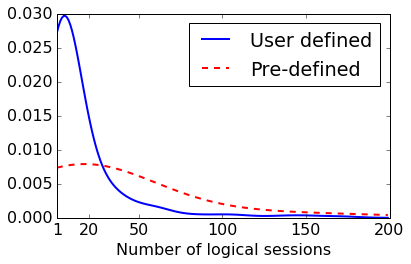

In [14]:
def task_queries():
    # Queries in logical sessions
    T, T_user, T_pre = {}, {}, {}
    # Logical session counts
    S, S_u, S_p, S_q = {}, {}, {}, {}
    for userid, ua in UA:
        l_sessions = logical_session(ua)
        
        # Queries in the logical sessions
        for session in l_sessions:
            # Filter out None tasks
            taskid = session[0][0]['taskid']
            qcount = len([e for e, on in session if e['event'] in query_events])
            if taskid == 'None':
                continue
            # Keep each person's pre-defined tasks separate
            if taskid in to_exclude:
                taskid = '%s_%s'%(taskid, userid)
                T_pre[taskid] = T_pre.get(taskid, 0) + qcount
                S_p[taskid] = S_p.get(taskid, 0) + 1
            else:
                T_user[taskid] = T_user.get(taskid, 0) + qcount
                S_u[taskid] = S_u.get(taskid, 0) + 1
            if qcount > 0:
                S_q[taskid] = S_q.get(taskid, 0) + 1
            # Count number of queries in each logical session
            T[taskid] = T.get(taskid, 0) + qcount
            S[taskid] = S.get(taskid, 0) + 1
            
    T = [(T[t], t) for t in T]
    T_pre = [(T_pre[t], t) for t in T_pre]
    T_user = [(T_user[t], t) for t in T_user]
    print "===================="
    print "Number of queries - tasks"
    print "===================="
    
    print "Total number of annotated user-defined tasks:", len(T_user) 
    
    # 0 queries
    print "percentage of 0 queries:"
    print "All data:",
    percentage_zero_queries(T)
    print "User defined tasks:",
    u_zero, u_nonzero = percentage_zero_queries(T_user)
    print "Pre defined tasks:",
    p_zero, p_nonzero = percentage_zero_queries(T_pre)
    # Difference between user and pre-defined:
    chi2, p, dof, ex = chi2_contingency([[u_zero, u_nonzero],[p_zero, p_nonzero]])
    print "chi2:", chi2, "p-value:", p, "dof:", dof
    print
    
    # Stats
    print "Stats of all sessions"
    # Stats of all data
    stats_querycount(T, 'less')
    # Stats of sessions with queries
    print
    
    print "Stats of tasks with queries"
    with_q = [q for q in T if q[0] > 0]
    stats_querycount(with_q, 'less')
    
    # Plots - number of logical sessions per task, i.e. revisits
    print 
    print "Number of sessions per task:"
    S = [S[s] for s in S]
    print "All tasks:", 
    print_desc_stats(S)
    one = S.count(1)
    print "one:", one, '>one:', len(S) - one, "revisit: %.4f"%(float(len(S) - one)/len(S))
    print
    print "Only for sessions with queries:"
    S_q = [S_q[s] for s in S_q]
    print "All tasks:", 
    print_desc_stats(S_q)
    one = S_q.count(1)
    print "one:", one, '>one:', len(S_q) - one, "revisit: %.4f"%(float(len(S_q) - one)/len(S_q))
    print    
    
    S_u = [S_u[s] for s in S_u]
    print "User defined tasks:", 
    print_desc_stats(S_u)
    one = S_u.count(1)
    print "one:", one, '>one:', len(S_u) - one, "revisit: %.4f"%(float(len(S_u) - one)/len(S_u))
    print
    
    S_p = [S_p[s] for s in S_p]
    print "Pre defined tasks:", 
    print_desc_stats(S_p)
    one = S_p.count(1)
    print "one:", one, '>one:', len(S_p) - one, "revisit: %.4f"%(float(len(S_p) - one)/len(S_p))
    print
    
    X = range(1, 200)
    density_plot(S_u, X, 'b-', hold=False)
    density_plot(S_p, X, 'r--', hold=True)
    pylab.legend(['User defined', 'Pre-defined'])
    pylab.xlabel('Number of logical sessions')
    pylab.xlim([1, 200])
    pylab.xticks([1, 20, 50, 100, 150, 200])
    pylab.tight_layout()
    figure = '%s/number_lsession_task.eps'%outputdir
    pylab.savefig(figure)
            
task_queries()

## Timespan
 - Logical session timespans (stats, distribution) 
     * user vs. pre defined tasks
     * with vs. without queries
 
 - task timespans (stats, distribution)
     * user vs. pre defined tasks
     * with vs. without queries

In [15]:
def in_hours(data):
    return [d/60. for d in data] 
def in_seconds(data):
    return [d*60 for d in data]

def stats_logical(L):
    # Stats: min, max, median, mean
    print "Timespan for logical sessions ========"
    print "All data (mins):", 
    X = [l[0] for l in L]
    print_desc_stats(X)
    print "hrs - ",
    print_desc_stats(in_hours(X))
    print "secs - ",
    print_desc_stats(in_seconds(X))
    print
    
    print "Data with queries (mins)",
    Y = [l[0] for l in L if l[2] > 0]
    print_desc_stats(Y)
    print "hrs - ",
    print_desc_stats(in_hours(Y))
    print "secs - ",
    print_desc_stats(in_seconds(Y))
    print 
    
    print "Difference between all tasks and with query tasks timespan:", 
    m, p = mannwhitneyu(X, Y, 'less')
    ef = ef_MU(X, Y, h='less')
    print "m:", m, "p-value: %.3f"%p, "ef: %.3f"%ef
    print 
    
def stats_task(L):
    # Aggregate L in to tasks
    T = [] 
    T_q = []
    L.sort(key=lambda x: x[1])
    for k, g in itertools.groupby(L, lambda x: x[1]):
        g = list(g)
        time = sum([gg[0] for gg in g])
        qcount = sum([gg[2] for gg in g])
        T.append((time, k, qcount))
    # stats: min, max, median, mean
    print "Timespan for tasks ============"
    print "All data (mins):", 
    X = [t[0] for t in T]
    print_desc_stats(X)
    print "hrs - ",
    print_desc_stats(in_hours(X))
    print "secs - ",
    print_desc_stats(in_seconds(X))
    print    

    print "Data with queries:",
    Y = [t[0] for t in T if t[2] > 0]
    print_desc_stats(Y)
    print "hrs - ",
    print_desc_stats(in_hours(Y))
    print "secs - ",
    print_desc_stats(in_seconds(Y))
    print

    print "Difference between all tasks and with query tasks timespan:", 
    m, p = mannwhitneyu(X, Y, 'less')
    ef = ef_MU(X, Y, h='less')
    print "m:", m, "p-value: %.3f"%p, "ef: %.3f"%ef
    print 
    
    
    
def time_span():
    L = []
    for userid, ua in UA:
        l_sessions = logical_session(ua)
        
        # Queries in the logical sessions
        for session in l_sessions:
            taskid = session[0][0]['taskid']
            # Filter out None tasks
            if taskid == 'None':
                continue
            span = (session[-1][0]['timestamp_bson'] - session[0][0]['timestamp_bson']).total_seconds()/60
            qcount = len([e for e, on in session if e['event'] in query_events])
            # Keep each person's pre-defined tasks separate
            if taskid in to_exclude:
                taskid = '%s_%s'%(taskid, userid)
            # Count number of queries in each logical session
            L.append((span, taskid, qcount))
            
    stats_logical(L)
    stats_task(L)
    
time_span()


Timespan for logical sessions ========
All data (mins): Min: 1.66666666667e-05 Max: 252.654083333 mean: 1.87 median: 0.215383333333
hrs -  Min: 2.77777777778e-07 Max: 4.21090138889 mean: 0.03 median: 0.00358972222222
secs -  Min: 0.001 Max: 15159.245 mean: 112.34 median: 12.923

Data with queries (mins) Min: 3.33333333333e-05 Max: 125.806066667 mean: 2.24 median: 0.321708333333
hrs -  Min: 5.55555555556e-07 Max: 2.09676777778 mean: 0.04 median: 0.00536180555556
secs -  Min: 0.002 Max: 7548.364 mean: 134.13 median: 19.3025

Difference between all tasks and with query tasks timespan: less
m: 6446446.5 p-value: 0.000 ef: 0.539

Timespan for tasks ============
All data (mins): Min: 3.33333333333e-05 Max: 868.996616667 mean: 44.82 median: 10.4501833333
hrs -  Min: 5.55555555556e-07 Max: 14.4832769444 mean: 0.75 median: 0.174169722222
secs -  Min: 0.002 Max: 52139.797 mean: 2689.35 median: 627.011

Data with queries: Min: 3.33333333333e-05 Max: 868.996616667 mean: 57.99 median: 15.71265
hrs 

## Map of events

* Note: we filter out event where 
 - users are not "on" tab
 - None tasks
 - logical sessions last less than 0 second

In [26]:
def map_events():
    # Get events that are annotated with tasks
    annotated_events = []
    for userid, ua in UA:
        lsession = logical_session(ua)
        events = []
        for session in lsession:
            for e, on in session:
                # Note that events like omni_keyword will follow the tab-search event, 
                # which is a double count for querying events
                if get_event_category(e['event']) == 'query':
                    if e['event'] in query_events:
                        events.append('query')
                    else:
                        continue
                else:
                    events.append(get_event_category(e['event']))

        annotated_events += events

    annotated_events.sort()
    for k, g in itertools.groupby(annotated_events):
        print k, len(list(g))

map_events()
    
    
    
    

? 3311
form_submit 5120
forward/backward 798
link_click 24393
pagination 48
query 2694
tab_close 4095
tab_load 33602
tab_new 4917
tab_switch 11258
type_in_url 4032


In [17]:
def basic_stats():
    all_events = [(x[0]['event'], x[0]['taskid']) for userid, ua in UA for x in ua]
    all_tasks = list(UserTasks.find({}))
    chosen_tasks = []
    for u in User.find({}):
        postQ = u.get('postQ', {})
        tasklist = postQ.get('tasklist', [])
        for t in tasklist:
            if t['chosen'] == True:
                chosen_tasks.append(t)
    
    # Number of queries annotated
    Q = [q for q in all_events if q[0] in query_events]
    Q_annotated = [q for q in Q if not q[1] == 'None']
    Q_user = [q for q in Q_annotated if not q[1] in to_exclude]
    print "Number of queries:", len(Q), 'Annotated:', len(Q_annotated), 'User defined tasks:', len(Q_user)
    
    # Number of tasks
    T = set([t[1] for t in all_events if t[1] not in ['None'] + to_exclude])
    T_registered = [str(t['_id']) for t in all_tasks]
    print "Number of user defined tasks used in annotation:", len(T)
    print "Note: if we exclude tasks that last 0 seconds then the number should be 289"
    
    
basic_stats()    

Number of queries: 2694 Annotated: 2566 User defined tasks: 1768
Number of user defined tasks used in annotation: 291
Note: if we exclude tasks that last 0 seconds then the number should be 289
